We are given a c.c. compounded yield curve.

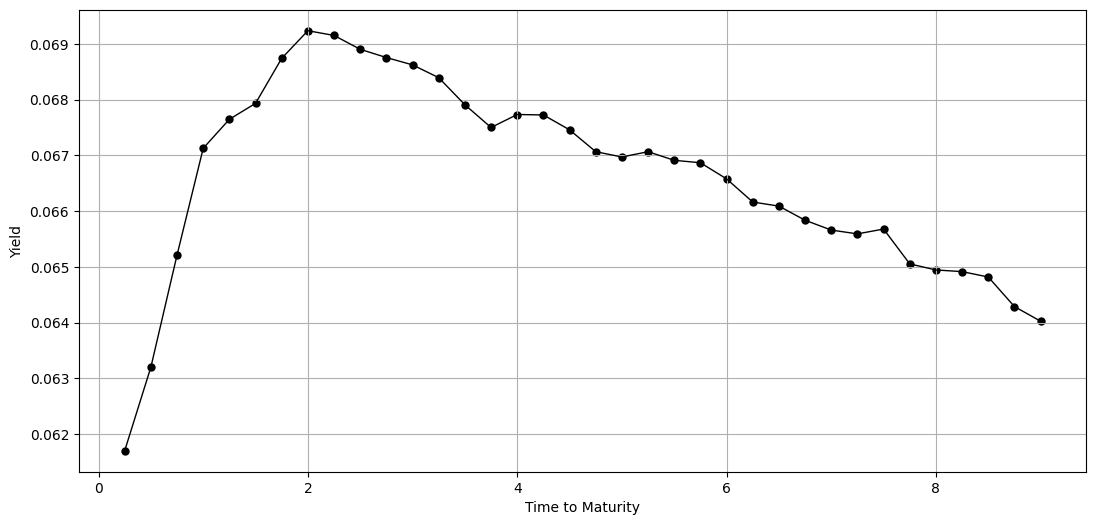

In [2466]:
import numpy as np
import matplotlib.pyplot as plt

maturities = np.arange(0.25, 9.25, 0.25)
yields = [0.0617010, 0.0632000, 0.0652114, 0.0671270, 0.0676471, 0.0679336, 0.0687412, 0.0692366, 0.0691518, 0.0689033, 0.0687555, 0.0686239, 
          0.0683940, 0.0679085, 0.0675003, 0.0677334, 0.0677255, 0.0674582, 0.0670663, 0.0669710, 0.0670661, 0.0669115, 0.0668679, 0.0665782,
          0.0661633, 0.0660896, 0.0658362, 0.0656600, 0.0655917, 0.0656780, 0.0650526, 0.0649443, 0.0649143, 0.0648180, 0.0642875, 0.0640249]

#Visualize the yield curve
plt.figure(figsize=(13, 6))
plt.plot(maturities, yields, color='black', linewidth=1)
plt.scatter(maturities, yields, color='black', linewidth=0.01)
plt.xlabel('Time to Maturity')
plt.ylabel('Yield')
plt.grid(True)
plt.show()


We start by fitting the Vasicek model to it using the procedure in section 15.2.4. Assume that $r(0) = 0.06$ 

Optimized gamma_star: 0.534728389667964
Optimized r_bar_star: 0.10343141908380418
Optimized sigma: 0.15742212502735928


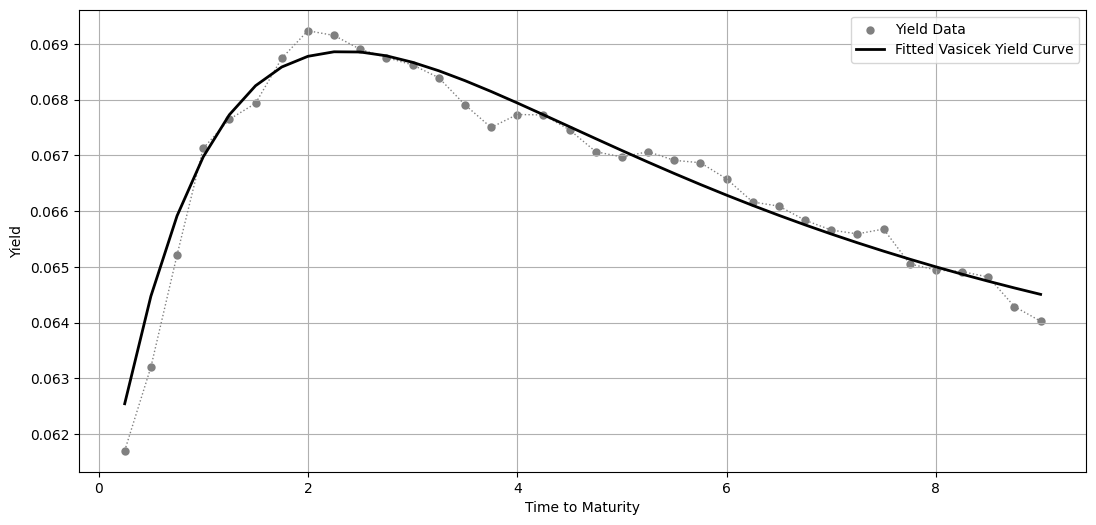

In [2467]:
from scipy.optimize import minimize

def vasicek_ZCB(gamma, r_bar, r0, sigma, maturity):
    b = 1/gamma * (1 - np.exp(-gamma * maturity))
    a = (b - maturity) * (r_bar - sigma**2 / (2 * gamma**2)) - sigma**2 * b**2 / (4 * gamma)
    z = np.exp(a - b * r0)
    return z


def vasicek_yield(gamma, r_bar, r0, sigma, maturity):
    return -np.log(vasicek_ZCB(gamma, r_bar, r0, sigma, maturity)) / maturity


def loss_function(params, r0, observed_prices, maturities):
    gamma_star, r_bar_star, vol = params
    model_prices = [vasicek_ZCB(gamma_star, r_bar_star, r0, vol, mat) for mat in maturities]
    errors = np.array(model_prices) - np.array(observed_prices)
    return np.sum(errors**2)


initial_params = [0.5, 0.05, 0.02] # gamma, r_bar, sigma
r_0 = 0.06
observed_prices = [np.exp(-yeld * mat) for yeld, mat in zip(yields, maturities)]


result = minimize(
    loss_function,
    initial_params, 
    args=(r_0, observed_prices, maturities),
    bounds=[(0.001, None), (0, None), (0, None)]
)

gamma_opt, r_bar_star_opt, vol_opt = result.x

print("Optimized gamma_star:", gamma_opt)
print("Optimized r_bar_star:", r_bar_star_opt)
print("Optimized sigma:", vol_opt)

# Plot fitted Vasicek yield curve against observed yields
fitted_yields_vasicek = [vasicek_yield(gamma_opt, r_bar_star_opt, r_0, vol_opt, mat) for mat in maturities]
plt.figure(figsize=(13, 6))
plt.plot(maturities, yields, color='grey', linewidth=1, linestyle=':')
plt.scatter(maturities, yields, color='grey', linewidth=0.01, label='Yield Data')
plt.plot(maturities, fitted_yields_vasicek, color='black', linestyle='-', linewidth=2, label='Fitted Vasicek Yield Curve')
plt.xlabel('Time to Maturity')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()


Let's now try to fit the Ho-Lee model to the same data.

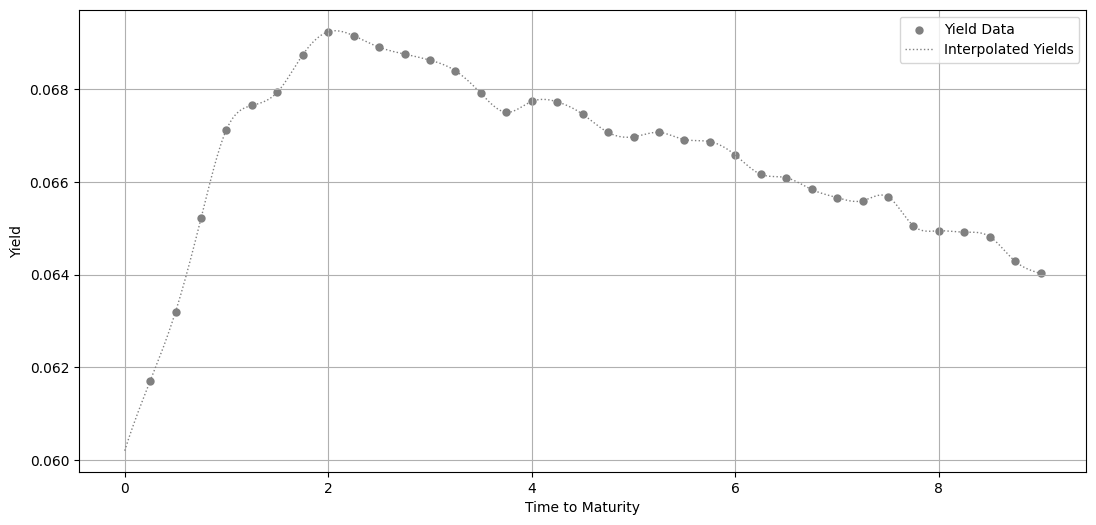

In [2468]:
from scipy.interpolate import CubicSpline

# Interpolate the yield curve
yield_spline = CubicSpline(maturities, yields, bc_type='natural')
delta = 0.01
t_values = np.arange(0, maturities.max() + delta, delta) # 0, 0.01, 0.02,..., 8.99, 9.0

# Interpolated yields on the fine grid
r_t = yield_spline(t_values)
r_t_plus_delta = yield_spline(t_values + delta)

plt.figure(figsize=(13, 6))
plt.scatter(maturities, yields, color='grey', linewidth=0.01, label='Yield Data')
plt.plot(t_values, r_t, color='grey', linewidth=1, label='Interpolated Yields', linestyle=':')
plt.xlabel('Time to Maturity')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

Now use $f(0, t) = r(0, t) + t \times \frac{r(0, t+\delta) - r(0, t)}{\delta} $ to obtain the forward curve

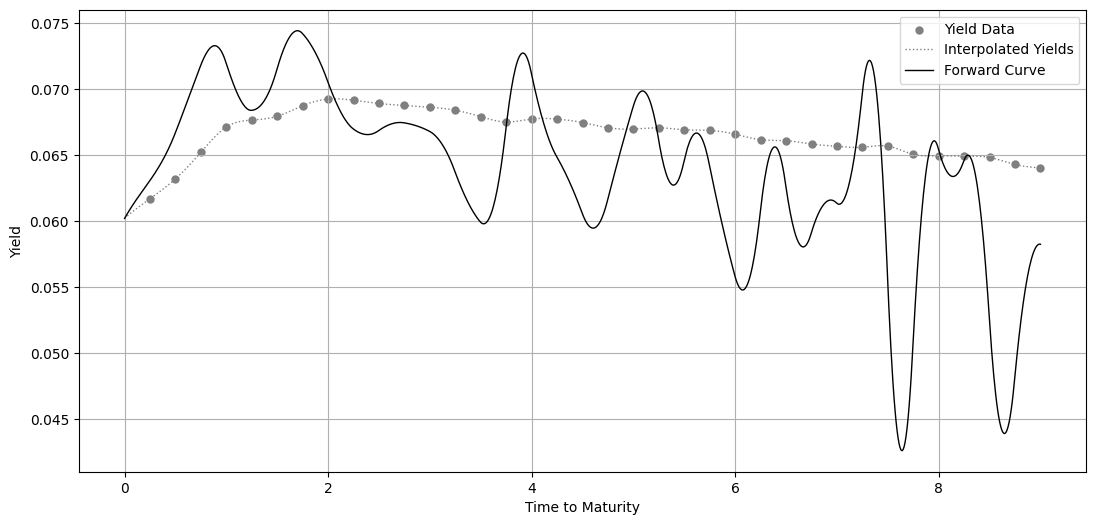

In [2469]:
# Instantaneous forward curve
f_t = r_t + t_values * (r_t_plus_delta - r_t) / delta

forward_curve_plot = plt.figure(figsize=(13, 6))
plt.scatter(maturities, yields, color='grey', linewidth=0.01, label='Yield Data')
plt.plot(t_values, r_t, color='grey', linewidth=1, label='Interpolated Yields', linestyle=':')
plt.plot(t_values, f_t, color='black', linewidth=1, label='Forward Curve')
plt.xlabel('Time to Maturity')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)


Finally to find $\theta_t$ we utilize,

$$
\theta_t \approx \frac{f(0, t+\delta) - f(0, t)}{\delta} + \sigma^2 \times t
$$

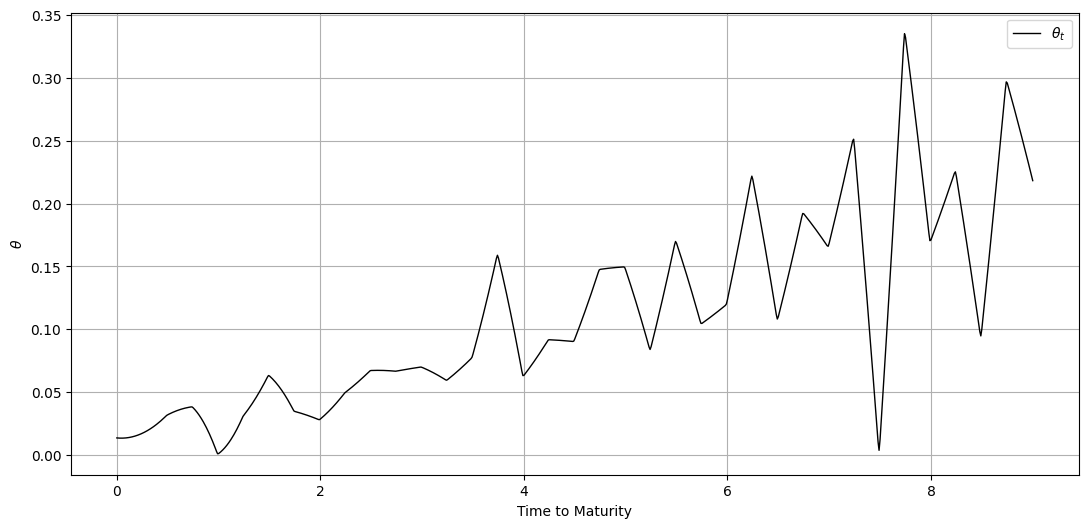

In [2470]:
sigma = vol_opt

# Find f(0, t + delta) for numerical differentiation
r_t_plus_2delta = yield_spline(t_values + 2 * delta)
f_t_plus_delta = r_t_plus_delta + (t_values + delta) * (r_t_plus_2delta - r_t_plus_delta) / delta

theta_t = (f_t_plus_delta - f_t) / delta + sigma**2 * t_values

theta_function_plot = plt.figure(figsize=(13, 6))
plt.plot(t_values, theta_t, color='black', linewidth=1, label=r'$\theta_t$')
plt.xlabel('Time to Maturity')
plt.ylabel(r'$\theta$')
plt.legend()
plt.grid(True)

Now make a plot of the Ho-Lee spot curve and the empirical data. To find the Ho-Lee spot use

$$
\begin{align*}
    r_0^{\text{Ho-Lee}(T)} &= -\frac{\ln(Z(r, 0, T))}{T} \\
    Z(r, 0, T) &= e^{-\int_0^T (T-t) \theta_t dt + \frac{T^3}{6} \sigma^2 - T\times r_0}
\end{align*}
$$

And approximate the integral using

$$
\begin{equation*}
    \int_0^T \theta_t (T-t) dt \approx \sum_{j=1}^n \theta_{j\times\delta} \times (T - j\delta)\times\delta
\end{equation*}
$$

/var/folders/04/0g4qzky921j9gpccwjp2ql6r0000gn/T/ipykernel_65580/2331481149.py:25: RuntimeWarning: invalid value encountered in divide
  r_HoLee = -np.log(Z_0T) / t_values


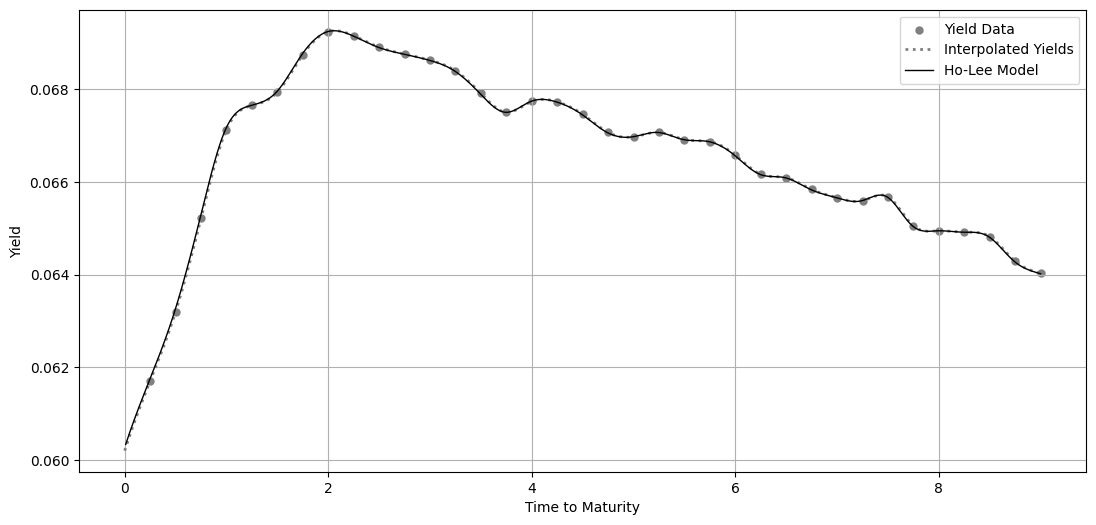

In [ ]:
# Compute A(0, T) for each maturity T using the approx method
A_T = []
for T in t_values:
    # Select t_j values up to T
    indices = t_values <= T
    t_j = t_values[indices]
    theta_j = theta_t[indices]
    
    # Compute the summation for the integral
    integrand = theta_j * (T - t_j)
    integral = np.sum(integrand * delta)
    
    # Compute A(0, T)
    A = -integral + (T**3) * sigma**2 / 6
    A_T.append(A)
A_T = np.array(A_T)

# Set r_0 as the instantaneous short rate at t=0
r_0 = r_t[0]

# Compute Z(0, T)
Z_0T = np.exp(A_T - t_values * r_0)

# Compute model yields
r_HoLee = -np.log(Z_0T) / t_values


ho_lee_vs_empirical_plot = plt.figure(figsize=(13, 6))
plt.scatter(maturities, yields, color='grey', linewidth=0.01, label='Yield Data')
plt.plot(t_values, r_t, color='grey', linewidth=2, label='Interpolated Yields', linestyle=':')
plt.plot(t_values, r_HoLee, color='black', linewidth=1, label='Ho-Lee Model')
plt.xlabel('Time to Maturity')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

Now plot the difference between the observed yield and the yield implied by the Vasicek model and the yield implied by Ho-Lee.

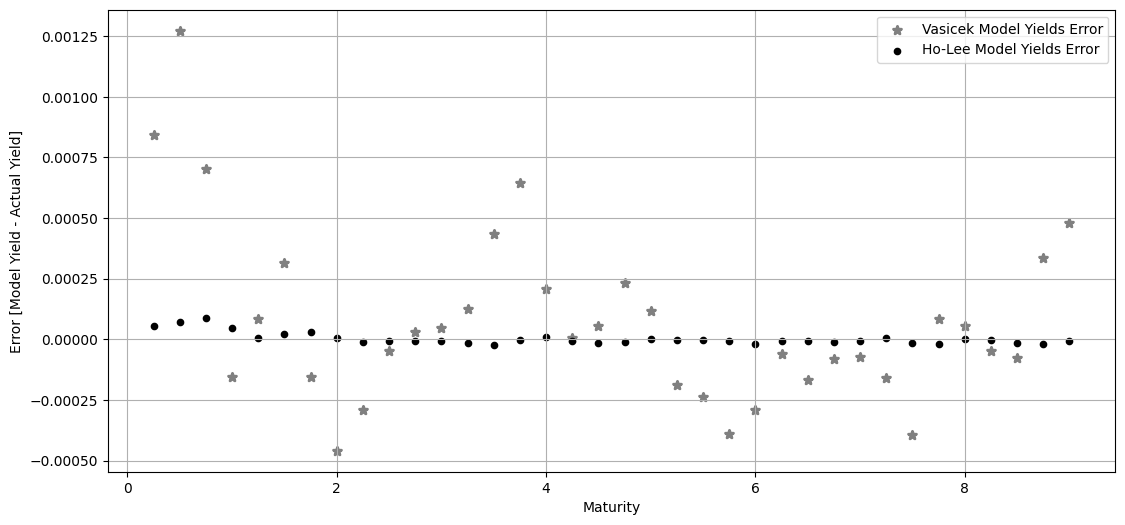

In [2472]:
vasicek_diff = np.array([fitted_yields_vasicek]) -np.array([yields])
ho_lee_diff = r_HoLee - r_t
# Filter ho_lee_diff to match maturities
matching_indices = np.isin(t_values, maturities)
filtered_ho_lee_diff = ho_lee_diff[matching_indices]

# Plot the filtered data
plt.figure(figsize=(13, 6))
plt.scatter(maturities, vasicek_diff, color='grey', linewidths=2, marker='*', label='Vasicek Model Yields Error')
plt.scatter(maturities, filtered_ho_lee_diff, color='black', linewidths=2.5, marker='.', label='Ho-Lee Model Yields Error')
plt.ylabel('Error [Model Yield - Actual Yield]')
plt.xlabel('Maturity')
plt.legend()
plt.grid(True)
plt.show()